1. Set Up


In [ ]:
import tensorflow as tf
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  2. Load Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Generates a dataset useable by TensorFlow from the images of the given directory
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/pml/Grapevine_Leaves_Image_Dataset',
                                                   class_names=['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli'])

Found 495 files belonging to 5 classes.


In [ ]:
class_names = data.class_names

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[1]

array([2, 1, 4, 3, 2, 4, 3, 4, 2, 3, 1, 3, 0, 2, 2, 2, 4, 1, 2, 2, 0, 4,
       2, 0, 0, 4, 1, 3, 2, 4, 4, 3], dtype=int32)

In [ ]:
# Gives the position of the last readable pixel in the x axis.
# Serves no real purpose, just as a checkpoint in the code.

batch[0].min()

6.563938

In [ ]:
batch[0].max()

255.0

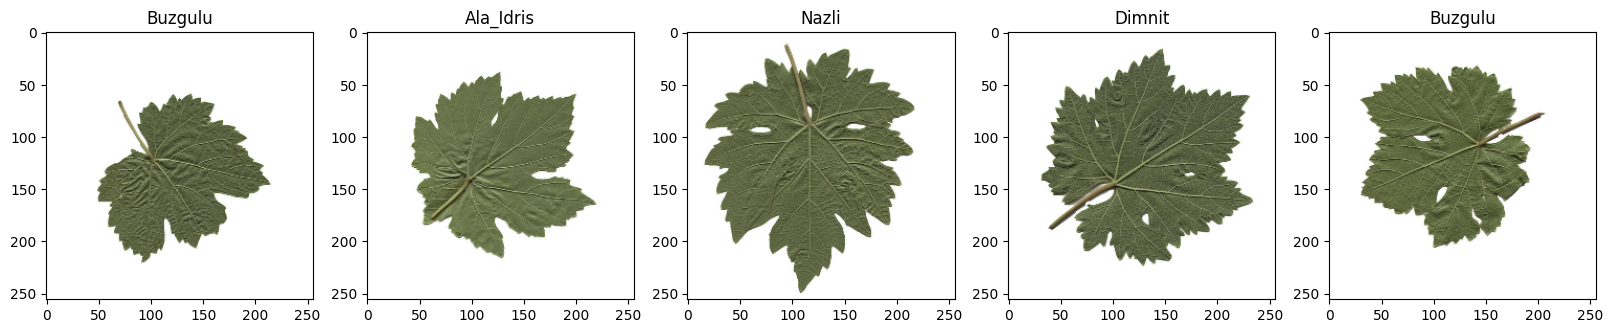

In [ ]:
# Plot the first five images from the list in use
fig, ax = plt.subplots(ncols=5, figsize=(20,20))

for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])

3. Preprocess Data

In [ ]:
# Reduces the values to speed up the access of the values from memory
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data_iterator = iter(data)

In [ ]:
batch = next(data_iterator)

In [ ]:
max_value = batch[0].numpy().max()

print("Maximum value:", max_value)

Maximum value: 1.0


In [ ]:
min_value = batch[0].numpy().min()

print("Minimum value:", min_value)

Minimum value: 0.028645834


4. Split Data

In [ ]:
# Number of lists comprising of 32 images each
len(data)

16

In [ ]:
# Devide the lists for different use cases, train, validation and test.
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

train_size + val_size + test_size

16

In [ ]:
# Create variables for each use case
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

5. Build Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# Applying transformations to the output through ReLu, MaxPooling2D and Conv2D in a sequential order throughout the layers
# The number of filters on the Conv2D is increased on each layer, on a constant (3,3) kernel and with a stride of 1
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3),1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [ ]:
# Configure the model for training using the 'Adam' optimizer for the gradient descent optimization
model.compile(optimizer='Adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

6. Train

In [ ]:
logdir = 'performance'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Train the model
hist = model.fit(train, batch_size=32, epochs=20, validation_data= val, callbacks=[tensorboard_callback])

7. Performance

In [ ]:
# Plot the loss and validation loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Plot the accuracy and validation accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Use the 'test' lists to create a confusion matrix
test_images, test_labels = next(iter(test))
predictions = np.argmax(model.predict(test_images), axis=-1)
cm = confusion_matrix(test_labels, predictions)

In [ ]:
# Plots the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

8. Evaluate Performance

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Redundant command as it is similar as the one for the confusion matrix creation
# Uses the test images to predict what the variaty is for each one using the trained model
test_images, test_labels = next(iter(test))
predictions = np.argmax(model.predict(test_images), axis=-1)

In [ ]:
report = classification_report(test_labels, predictions)

In [ ]:
print(report)

9. Test Model Performance

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Load and preprocess test images
test_image_paths = ['/content/drive/MyDrive/pml/test_images/Ak (100).png', '/content/drive/MyDrive/pml/test_images/Ala_Idris (100).png', '/content/drive/MyDrive/pml/test_images/Buzgulu (100).png','/content/drive/MyDrive/pml/test_images/Dimnit (100).png','/content/drive/MyDrive/pml/test_images/Nazli (100).png']

In [ ]:
# Creates a list of the test images and convertes them to the size of the images from the dataset
test_images = []
for image_path in test_image_paths:
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    preprocessed_img = img_array / 255.0  # Scale pixel values between 0 and 1
    test_images.append(preprocessed_img)

In [ ]:
test_images = np.array(test_images)

In [ ]:
# Predicts the grape's variety
predictions = np.argmax(model.predict(test_images), axis=-1)

In [ ]:
# Compares model's prediction against the true image label
class_names = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

for i in range(len(test_images)):
    image = test_images[i]
    predicted_label = predictions[i]
    true_label = class_names[i]

    plt.imshow(image)
    plt.title(f'Predicted: {class_names[predicted_label]}, True: {true_label}')
    plt.show()

10. Save the model

In [ ]:
model.save('/content/drive/MyDrive/pml')

In [ ]:
model.save('model_test_01.h5')